# News Category Classification AG News

##      Import Dependencies


In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


##       Load and Prepare Data


In [2]:
# Load training and testing datasets
train_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
test_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv')

# Combine both datasets into one DataFrame
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# (Optional) Save combined data
# combined_df.to_csv('combined_data.csv')

# Set 'Class Index' as the DataFrame index
df.set_index('Class Index', inplace=True)

# Concatenate 'Title' and 'Description' into a single text field
df['text'] = df['Title'] + " " + df['Description']

# Adjust labels: convert to 0-based index
df['label'] = df.index - 1 

# Preview the processed DataFrame
print(df.head())

                                                         Title  \
Class Index                                                      
3            Wall St. Bears Claw Back Into the Black (Reuters)   
3            Carlyle Looks Toward Commercial Aerospace (Reu...   
3              Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            Iraq Halts Oil Exports from Main Southern Pipe...   
3            Oil prices soar to all-time record, posing new...   

                                                   Description  \
Class Index                                                      
3            Reuters - Short-sellers, Wall Street's dwindli...   
3            Reuters - Private investment firm Carlyle Grou...   
3            Reuters - Soaring crude prices plus worries\ab...   
3            Reuters - Authorities have halted oil export\f...   
3            AFP - Tearaway world oil prices, toppling reco...   

                                                          text  label  
Cl

##    Download NLTK Resources


In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

##      Text Preprocessing

In [4]:
# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)                   # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)              # Keep only letters
    text = text.lower()                                 # Convert to lowercase
    tokens = nltk.word_tokenize(text)                   # Tokenize text
    tokens = [lemmatizer.lemmatize(w) for w in tokens 
              if w not in stop_words and w not in string.punctuation]  # Remove stopwords and punctuation
    return ' '.join(tokens)

# Apply preprocessing function to text
df['clean_text'] = df['text'].apply(preprocess_text)

# Ensure labels are categorical integers
df['label'] = df['label'].astype('category').cat.codes


##  Feature Extraction (TF-IDF)


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert text to TF-IDF vectors
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##    Train ML Classifiers

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Choose one classifier
clf = LogisticRegression(max_iter=1000)
# clf = RandomForestClassifier()
# clf = LinearSVC()

# Train and evaluate
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Show performance report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91      6283
           1       0.95      0.98      0.97      6466
           2       0.88      0.88      0.88      6370
           3       0.89      0.89      0.89      6401

    accuracy                           0.91     25520
   macro avg       0.91      0.91      0.91     25520
weighted avg       0.91      0.91      0.91     25520



##     Word Cloud Visualization

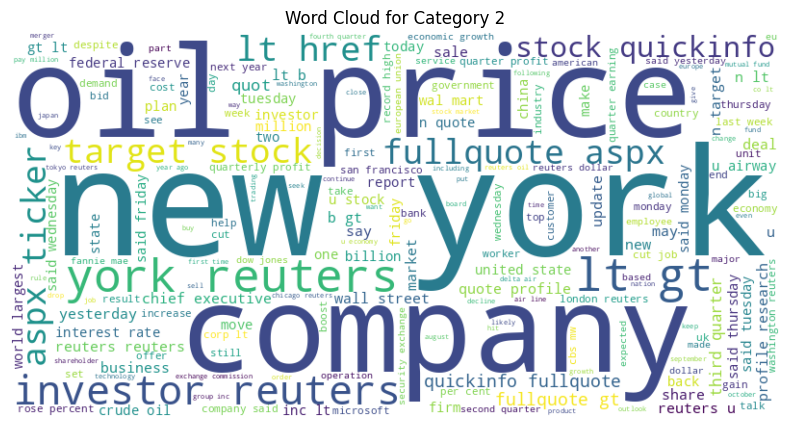

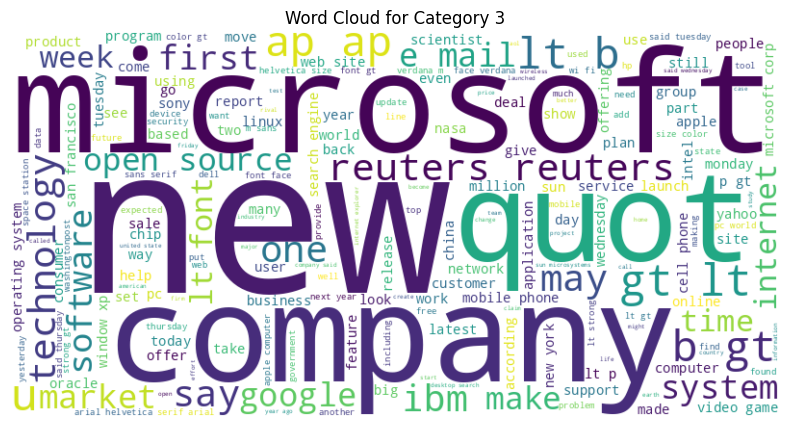

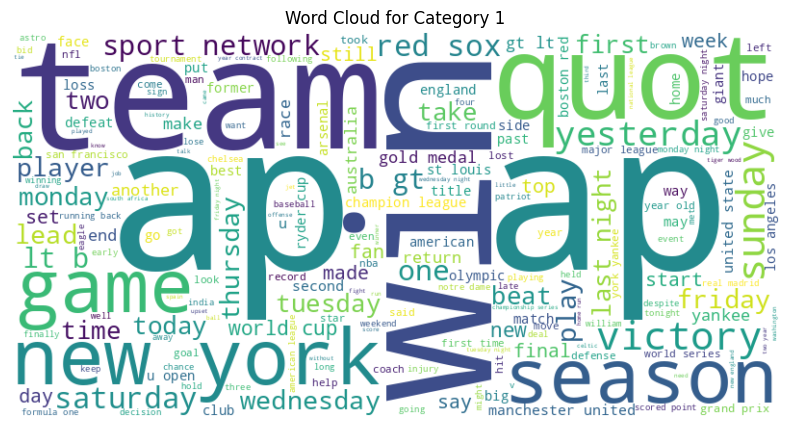

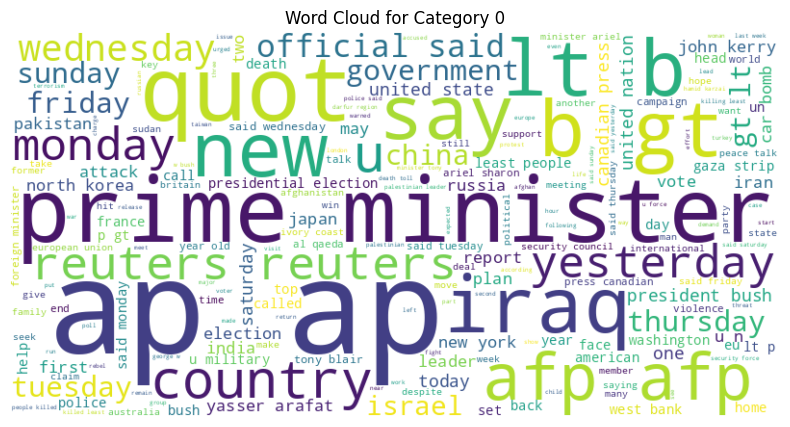

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generate and display word cloud for each label
for label in df['label'].unique():
    text = ' '.join(df[df['label'] == label]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Category {label}")
    plt.show()


##       Neural Network Model


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert sparse matrix to dense (required by Keras)
X_dense = X.toarray()
y_cat = to_categorical(y)

# Train/test split for neural network
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_dense, y_cat, test_size=0.2, random_state=42)

# Build a simple feedforward neural network
model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')  # Output layer with softmax for multiclass classification
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_nn, y_train_nn, epochs=5, batch_size=64, validation_split=0.1)

# Evaluate on test set
loss, acc = model.evaluate(X_test_nn, y_test_nn)
print(f"Test Accuracy: {acc:.2f}")

2025-07-22 22:09:00.204985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753222140.464606      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753222140.534120      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-22 22:09:25.898128: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call 

Epoch 1/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.8535 - loss: 0.4433 - val_accuracy: 0.9125 - val_loss: 0.2544
Epoch 2/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.9325 - loss: 0.1955 - val_accuracy: 0.9149 - val_loss: 0.2568
Epoch 3/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.9529 - loss: 0.1328 - val_accuracy: 0.9140 - val_loss: 0.2888
Epoch 4/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.9731 - loss: 0.0762 - val_accuracy: 0.9139 - val_loss: 0.3491
Epoch 5/5
1436/1436 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.9847 - loss: 0.0424 - val_accuracy: 0.9084 - val_loss: 0.4368
798/798 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9130 - loss: 0.4052
Test Accuracy: 0.91


##      XGBoost Classifier


In [9]:
import xgboost as xgb

# Instantiate and train XGBoost model
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_clf.fit(X_train, y_train)

# Predict and report results
y_pred_xgb = xgb_clf.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.91      0.88      0.89      6283
           1       0.92      0.96      0.94      6466
           2       0.87      0.86      0.87      6370
           3       0.86      0.86      0.86      6401

    accuracy                           0.89     25520
   macro avg       0.89      0.89      0.89     25520
weighted avg       0.89      0.89      0.89     25520

